# Exploratory Data Analysis

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data_final.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,PriceCategory,ProductPopularity,DayOfWeek,Month,IsWeekend,MonthlySalesTrend,CustomerLifetimeValue,AvgOrderValue,PurchaseFrequency,IsReturningCustomer
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,Medium,34128,Wednesday,December,0,886045.94,5303.48,17.16,35,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,High,1547,Wednesday,December,0,886045.94,5303.48,17.16,35,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,Medium,1875,Wednesday,December,0,886045.94,5303.48,17.16,35,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,High,2451,Wednesday,December,0,886045.94,5303.48,17.16,35,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,High,3657,Wednesday,December,0,886045.94,5303.48,17.16,35,1


# How do customer segments differ in terms of purchasing behavior and value?

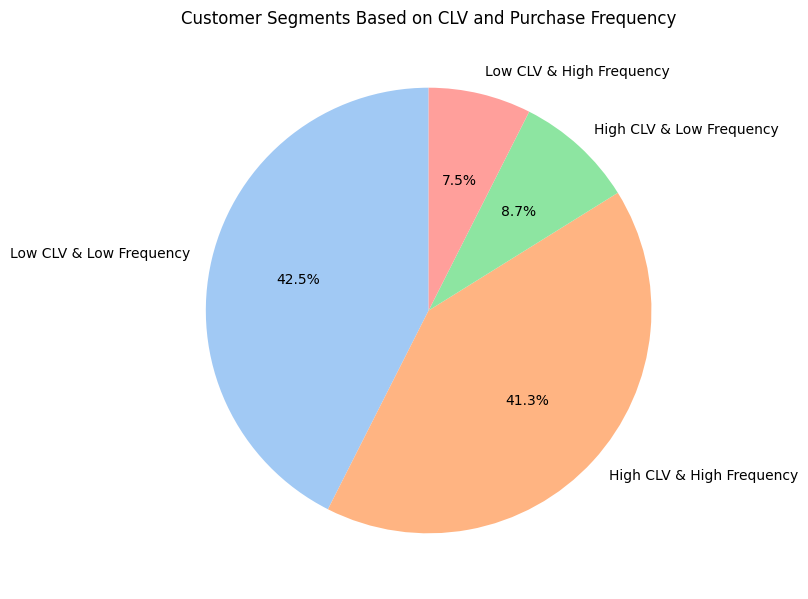

In [3]:
# Group customers based on CustomerLifetimeValue, AvgOrderValue, and PurchaseFrequency

# Calculate median values for segmentation
median_clv = df['CustomerLifetimeValue'].median()
median_pf = df['PurchaseFrequency'].median()

# Create segments
df['CustomerSegment'] = pd.cut(df['CustomerLifetimeValue'],
                                 bins=[-1, median_clv, df['CustomerLifetimeValue'].max()],
                                 labels=['Low CLV', 'High CLV'])

df['PurchaseSegment'] = pd.cut(df['PurchaseFrequency'],
                                 bins=[-1, median_pf, df['PurchaseFrequency'].max()],
                                 labels=['Low Frequency', 'High Frequency'])

# Convert the categorical columns to string before combining
df['CustomerSegment'] = df['CustomerSegment'].astype(str)
df['PurchaseSegment'] = df['PurchaseSegment'].astype(str)

# Combine the segments again
df['Segment'] = df['CustomerSegment'] + " & " + df['PurchaseSegment']

filtered_data = df[df['Segment'] != 'nan & Low Frequency']

# Prepare the data for the pie chart
segment_counts = filtered_data['Segment'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Customer Segments Based on CLV and Purchase Frequency')
plt.tight_layout()
plt.show()

The majority of customers are either High CLV and High Frequency (41.3%) or Low CLV and Low Frequency (42.5%)

# How does customer behavior vary across different countries?

C:\Users\KeetM\AppData\Local\Temp\ipykernel_19632\1417193468.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


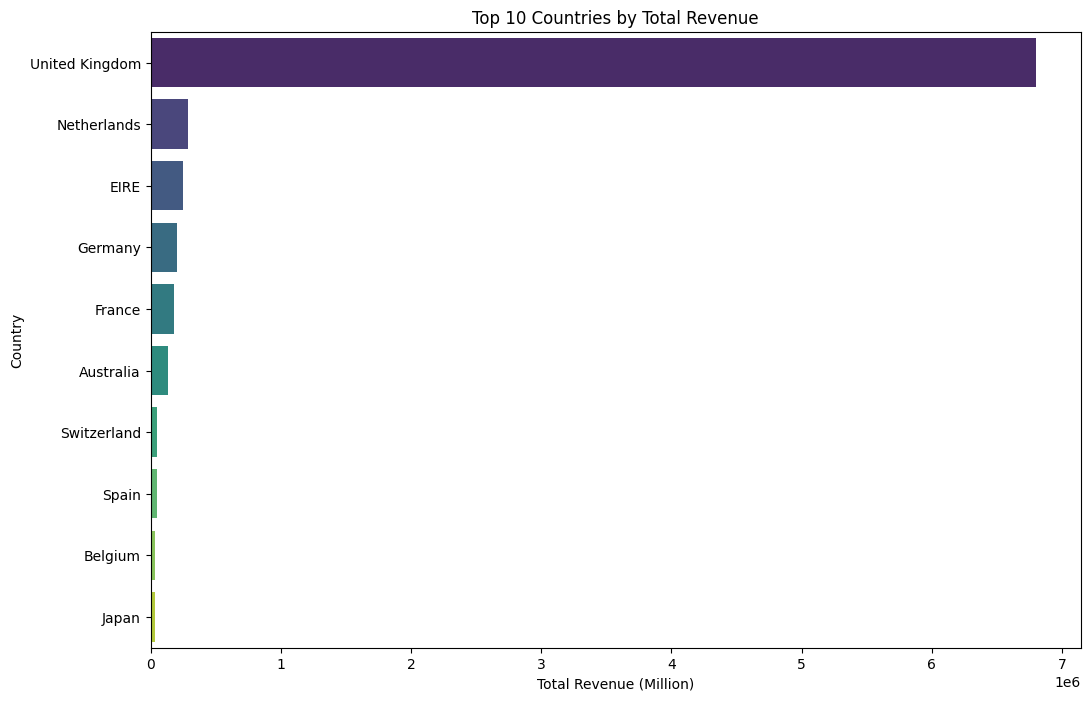

In [4]:
country_analysis = df.groupby('Country').agg({
    'TotalAmount': ['sum', 'mean'],  # Total and average revenue
    'InvoiceNo': 'count', # Number of orders (using invoice count as a proxy)
    'IsReturningCustomer': 'mean'  # Proportion of returning customers
}).reset_index()

# Rename columns for clarity
country_analysis.columns = ['Country', 'TotalRevenue', 'AvgOrderValue', 'OrderCount', 'ReturningCustomerRate']

# Sort data by total revenue in descending order
country_analysis = country_analysis.sort_values(by='TotalRevenue', ascending=False)

# Visualize the top 10 countries by total revenue
plt.figure(figsize=(12, 8))
sns.barplot(
    data=country_analysis.head(10),
    x='TotalRevenue', 
    y='Country',
    palette='viridis'
)
plt.title('Top 10 Countries by Total Revenue')
plt.xlabel('Total Revenue (Million)')
plt.ylabel('Country')
plt.show()


C:\Users\KeetM\AppData\Local\Temp\ipykernel_19632\2872042447.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sorted_countries.head(10), x='AvgOrderValue', y='Country', palette='magma')


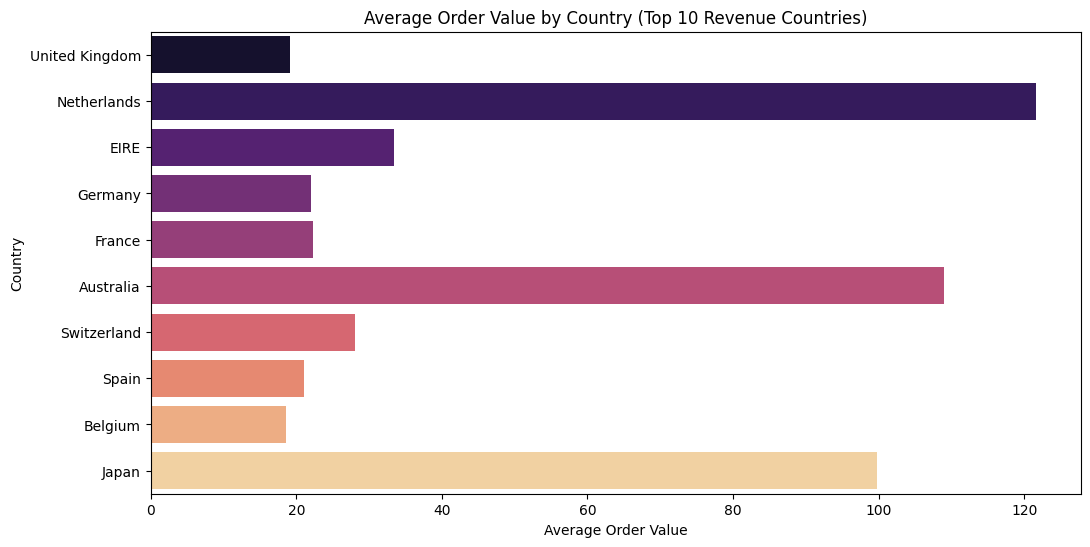

In [5]:
# Sort data by Total Revenue
sorted_countries = country_analysis.sort_values(by='TotalRevenue', ascending=False).reset_index(drop=True)

#Average Order Value by Country (Top 10 Revenue Countries)

plt.figure(figsize=(12, 6))
sns.barplot(data=sorted_countries.head(10), x='AvgOrderValue', y='Country', palette='magma')
plt.title('Average Order Value by Country (Top 10 Revenue Countries)')
plt.xlabel('Average Order Value')
plt.ylabel('Country')
plt.show()


Although the UK accounts for the vast majority of sales, the top 3 countries with the highest order values are the Netherlands, Australia and Japan respectively

# What are the monthly sales trends?

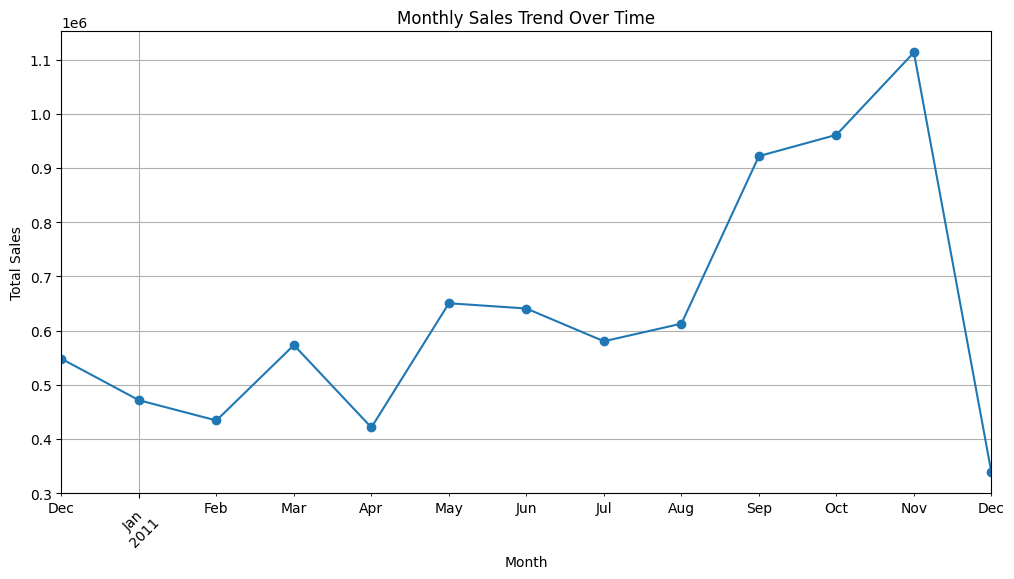

In [6]:
# Convert InvoiceDate to datetime format
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Aggregate total sales over time
sales_trend = df.groupby(df["InvoiceDate"].dt.to_period("M"))["TotalAmount"].sum()

# Plot sales trends over time
plt.figure(figsize=(12, 6))
sales_trend.plot(marker="o", linestyle="-")
plt.title("Monthly Sales Trend Over Time")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


sales peak in sept -> nov

# New vs Returning customers

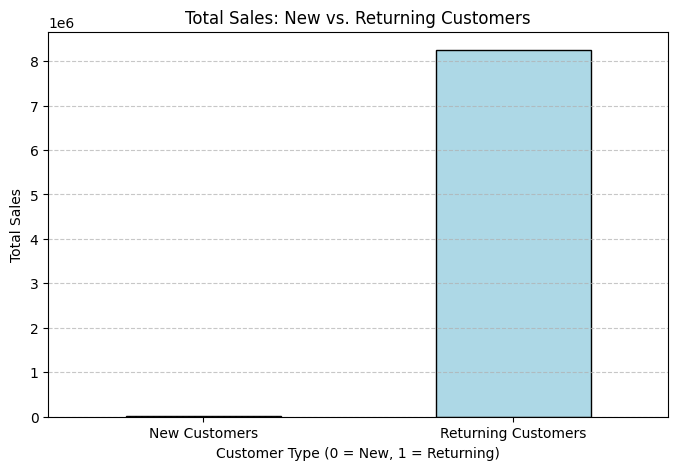

In [7]:
# Aggregate total sales for returning vs. new customers
customer_type_sales = df.groupby("IsReturningCustomer")["TotalAmount"].sum()

# Plot sales by customer type
plt.figure(figsize=(8, 5))
customer_type_sales.plot(kind="bar", color=["lightcoral", "lightblue"], edgecolor="black")
plt.title("Total Sales: New vs. Returning Customers")
plt.xlabel("Customer Type (0 = New, 1 = Returning)")
plt.ylabel("Total Sales")
plt.xticks([0, 1], ["New Customers", "Returning Customers"], rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


returning customers consist of the vast majority of sales

# Product popularity distribution

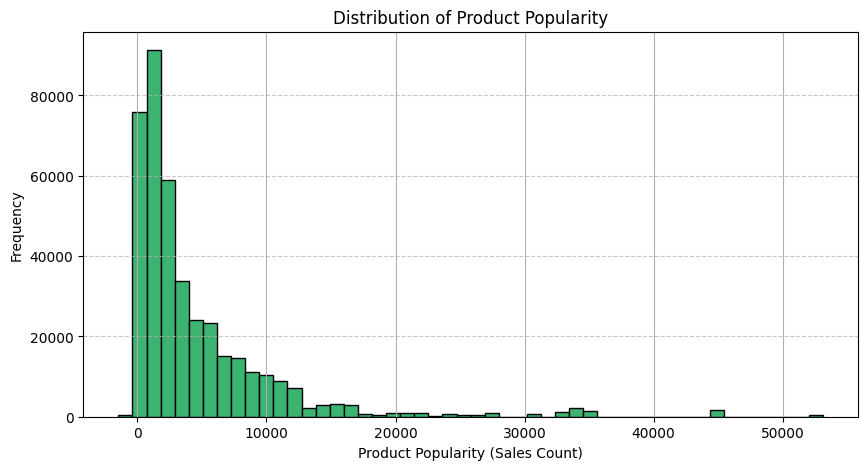

In [8]:
# Plot distribution of product popularity
plt.figure(figsize=(10, 5))
df["ProductPopularity"].hist(bins=50, edgecolor="black", color="mediumseagreen")
plt.title("Distribution of Product Popularity")
plt.xlabel("Product Popularity (Sales Count)")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


- The distribution is right-skewed, meaning a few products are extremely popular while most have lower sales.
- A small number of products drive most of the revenue, which aligns with the Pareto principle (80/20 rule) in sales.

# Total sales by Price Category

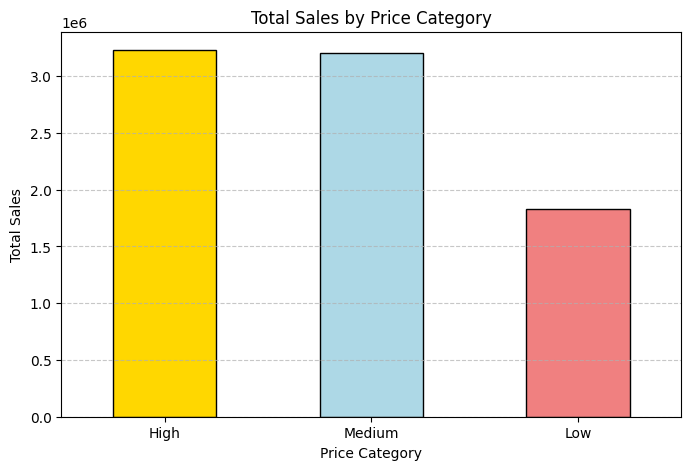

In [9]:
# Aggregate total sales by price category
sales_by_price_category = df.groupby("PriceCategory")["TotalAmount"].sum().sort_values(ascending=False)

# Plot sales by price category
plt.figure(figsize=(8, 5))
sales_by_price_category.plot(kind="bar", color=["gold", "lightblue", "lightcoral"], edgecolor="black")
plt.title("Total Sales by Price Category")
plt.xlabel("Price Category")
plt.ylabel("Total Sales")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Customers prefer medium and high priced products

# Distribution of CLV

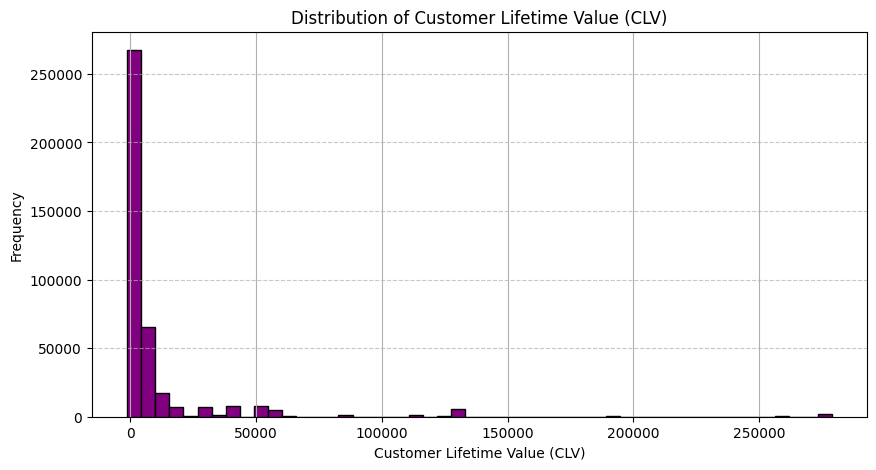

In [10]:
# Plot distribution of Customer Lifetime Value (CLV)
plt.figure(figsize=(10, 5))
df["CustomerLifetimeValue"].hist(bins=50, edgecolor="black", color="purple")
plt.title("Distribution of Customer Lifetime Value (CLV)")
plt.xlabel("Customer Lifetime Value (CLV)")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


# Purchase Frequency Analysis

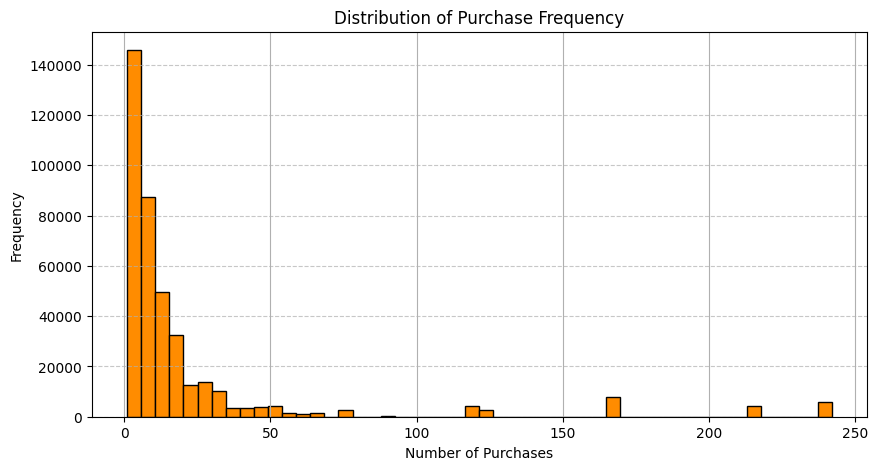

count    399689.000000
mean         22.555650
std          44.403024
min           1.000000
25%           4.000000
50%           8.000000
75%          17.000000
max         242.000000
Name: PurchaseFrequency, dtype: float64

In [12]:
# Plot distribution of Purchase Frequency
plt.figure(figsize=(10, 5))
df["PurchaseFrequency"].hist(bins=50, edgecolor="black", color="darkorange")
plt.title("Distribution of Purchase Frequency")
plt.xlabel("Number of Purchases")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Summary statistics for Purchase Frequency
purchase_frequency_summary = df["PurchaseFrequency"].describe()
purchase_frequency_summary


- The majority of customers make under 10 purchases.
- A small group of customers purchase very frequently, likely contributing significantly to revenue.